<a href="https://colab.research.google.com/github/RodrigoOBC/TCC-CienciaDados/blob/ModelosCompletos/Resnet_TCC_MB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import seaborn as sns
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.applications.efficientnet import *
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
import cv2
from glob import glob
from random import shuffle
import tensorflow as tf 
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.6.0


In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = r'/content/drive/MyDrive/TCC'
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
EPOCHS = 100

In [4]:
def montar_nome(path):
    nome_file = []
    file_path = []
    x = 0
    for p, _, files in os.walk(os.path.abspath(path)):
        for file_name in files:
            if file_name  == 'ResNet50.h5':
              continue
            else:
              nome_file.append(file_name)
              file_path.append(p+'//'+file_name)
    return nome_file, file_path

def selecionar_classe(nomes):
    classe = []
    for nome in nomes:
        nome = ''.join([i for i in nome if not i.isdigit()])
        nome = nome.split('.')[0]
        if "TA" == nome:
            classe.append('TA')
        elif "DCI" == nome:
            classe.append('DCI')
        elif "F" == nome:
            classe.append('F')
        elif "PT" == nome:
            classe.append('PT')
        elif "DC" == nome:
            classe.append('DC')
        elif "LC" == nome:
            classe.append('LC')
        elif "MC" == nome:
            classe.append('MC')
        elif "PC" == nome:
            classe.append('PC')
        elif 'A' == nome:
            classe.append('A')
    return classe

def pegar_tipos(file_path):
    tipo = []
    for path in file_path:
        path = path.split('/')
        if 'B' in path:
            tipo.append('B')
        if 'M' in path:
            tipo.append('M')
    return tipo

def pegar_ampliacao(file_path):
    ampliacao = []
    for path in file_path:
        if '40x' in path:
            ampliacao.append('40x')
        elif '100x' in path:
            ampliacao.append('100x')
        elif '200x' in path:
            ampliacao.append('200x')
        elif '400x' in path:
            ampliacao.append('400x')
    return ampliacao

def pegar_origem(file_path):
    origem = []
    for path in file_path:
        if 'treino' in path:
            origem.append('Te')
        elif 'Teste' in path:
            origem.append('Tr')
    return origem

def montar_data_frame(path):
    nome_file, file_path = montar_nome(path)
    classes = selecionar_classe(nome_file)
    tipos = pegar_tipos(file_path)
    ampliacaos = pegar_ampliacao(file_path)
    origem = pegar_origem(file_path)
    data = {'FikePath': file_path, 'Type': tipos, 'classes':classes,'Magnification':ampliacaos, 'DataSet':origem}
    df = pd.DataFrame.from_dict(data, orient='index')
    df = df.transpose()
    return df

In [14]:
df_geral_400x =  montar_data_frame(r'/content/drive/MyDrive/TCC/400x')
df_treino_400x = df_geral_400x[df_geral_400x['DataSet'] == 'Tr'][df_geral_400x['Magnification'] == '400x']
df_teste_400x = df_geral_400x[df_geral_400x['DataSet'] == 'Te'][df_geral_400x['Magnification'] == '400x']
df_treino_400x = df_treino_400x.drop(columns=['Magnification','DataSet'])
df_teste_400x = df_teste_400x.drop(columns=['Magnification','DataSet'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
print(f'quantidade de dados na base de Teste {df_teste_400x.shape[0]}')
print(f'quantidade de dados na base de Treino {df_treino_400x.shape[0]}')

quantidade de dados na base de Teste 978
quantidade de dados na base de Treino 786


In [19]:

df_treino_400x.head()

,FikePath,Type,classes
0,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M,DC
1,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M,DC
2,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M,DC
3,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M,DC
4,/content/drive/MyDrive/TCC/400x/400x_Teste/M//...,M,DC


In [20]:

df_teste_400x.head()

,FikePath,Type,classes
786,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M,DC
787,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M,DC
788,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M,DC
789,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M,DC
790,/content/drive/MyDrive/TCC/400x/400x_treino/M/...,M,DC


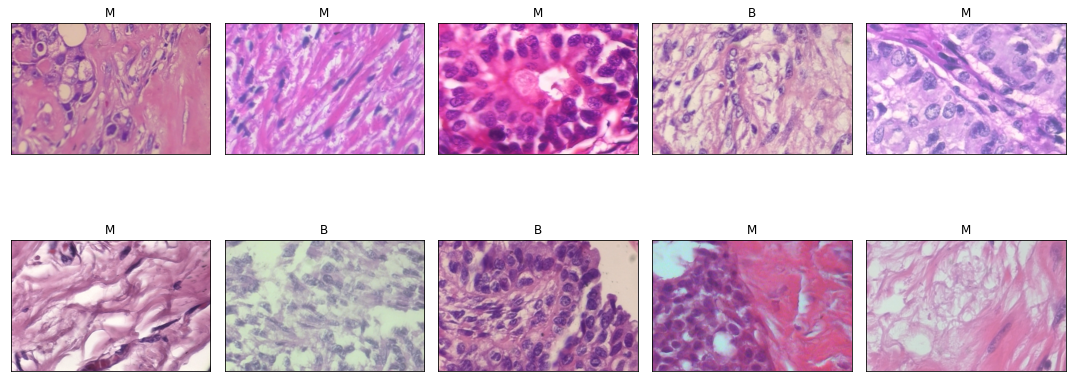

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,df_treino_400x.shape[0]-1)
    ax.imshow(plt.imread(df_treino_400x.FikePath[ponteiro]))
    ax.set_title(df_treino_400x.Type[ponteiro])
plt.tight_layout()
plt.show()

In [22]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)


In [23]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [24]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_400x,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_400x,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste_400x,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 629 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 978 validated image filenames belonging to 2 classes.


In [25]:
def build_model():
    base_ResNet = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)
    x = base_ResNet.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    preds = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(inputs = base_ResNet.input, outputs = preds)
    return model


In [28]:
Resnet_400 = build_model()
checkpoint_path = r'/content/drive/MyDrive/TCC/ResNet50MB.h5'
Resnet_400.load_weights(checkpoint_path)
Resnet_400.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________________

In [29]:
checkpoint_path = '/content/drive/MyDrive/TCC/ResNet50MB.h5'
stop = EarlyStopping(monitor='loss', mode='min', patience=10, restore_best_weights=True)
opt = Adam(learning_rate=0.0001)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)
Resnet_400.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [31]:
print("Realizando testes com modelo treinado para 400x")
pred = Resnet_400.predict(test_images)
pred=np.argmax(pred,axis=1)

Realizando testes com modelo treinado para 400x


In [33]:
pred_df=df_teste_400x.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9887525562372188


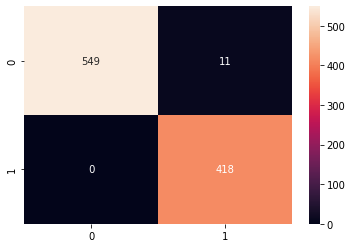

In [34]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d');

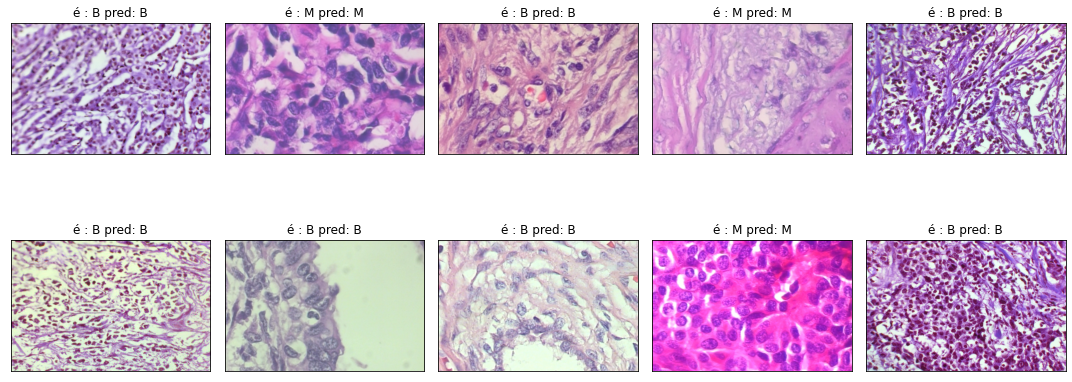

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,pred_df.shape[0]-1)
    ax.imshow(plt.imread(list(pred_df.FikePath)[ponteiro]))
    ax.set_title(f'é : {list(pred_df.Type)[ponteiro]} pred: {list(pred_df.pred)[ponteiro]}')
plt.tight_layout()
plt.show()

#Aqui começa a de 200
**negrito**

Primeiro iremos realizar um teste com os dados pré treinados de 400x, caso atinja uma valor aceitavel, ele será utilizado. Caso não seja, realizaremos um treinamento com 25 epocas

In [36]:
Resnet200 = build_model()
checkpoint_path = r'/content/drive/MyDrive/TCC/ResNet50MB.h5'
Resnet200.load_weights(checkpoint_path)
Resnet200.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = r'/content/drive/MyDrive/TCC'
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
EPOCHS = 100

In [48]:
df_geral_200x =  montar_data_frame(GCS_PATH+'/200x')
df_treino_200x = df_geral_200x[df_geral_200x['DataSet'] == 'Tr'][df_geral_200x['Magnification'] == '200x']
df_teste_200x = df_geral_200x[df_geral_200x['DataSet'] == 'Te'][df_geral_200x['Magnification'] == '200x']
df_treino_200x = df_treino_200x.drop(columns=['Magnification','DataSet'])
df_teste_200x = df_teste_200x.drop(columns=['Magnification','DataSet'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
print(f'quantidade de dados na base de Teste {df_teste_200x.shape[0]}')
print(f'quantidade de dados na base de Treino {df_treino_200x.shape[0]}')

quantidade de dados na base de Teste 856
quantidade de dados na base de Treino 787


In [50]:

df_teste_200x.head()

,FikePath,Type,classes
787,/content/drive/MyDrive/TCC/200x/200x_treino/M/...,M,DC
788,/content/drive/MyDrive/TCC/200x/200x_treino/M/...,M,DC
789,/content/drive/MyDrive/TCC/200x/200x_treino/M/...,M,DC
790,/content/drive/MyDrive/TCC/200x/200x_treino/M/...,M,DC
791,/content/drive/MyDrive/TCC/200x/200x_treino/M/...,M,DC


In [51]:

df_treino_200x.head()

,FikePath,Type,classes
0,/content/drive/MyDrive/TCC/200x/200x_Teste/B//...,B,A
1,/content/drive/MyDrive/TCC/200x/200x_Teste/B//...,B,A
2,/content/drive/MyDrive/TCC/200x/200x_Teste/B//...,B,A
3,/content/drive/MyDrive/TCC/200x/200x_Teste/B//...,B,A
4,/content/drive/MyDrive/TCC/200x/200x_Teste/B//...,B,A


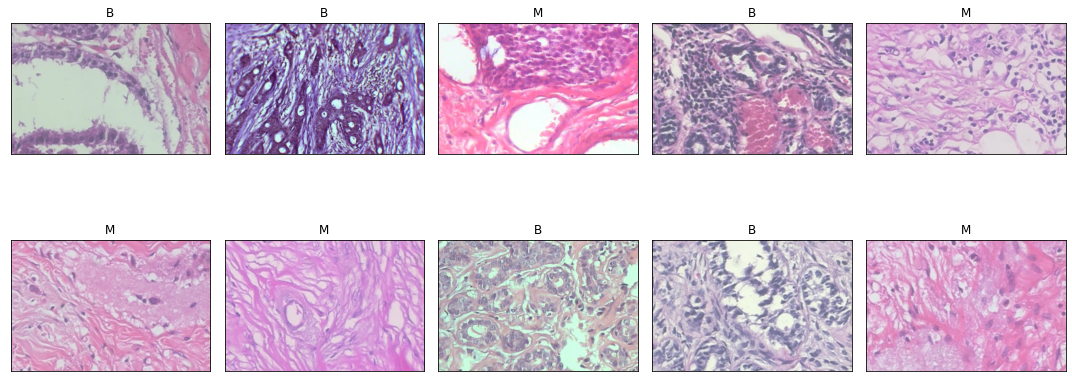

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,df_treino_200x.shape[0]-1)
    ax.imshow(plt.imread(list(df_treino_200x.FikePath)[ponteiro]))
    ax.set_title(list(df_treino_200x.Type)[ponteiro])
plt.tight_layout()
plt.show()

In [53]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [54]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_200x,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_200x,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste_200x,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 630 validated image filenames belonging to 2 classes.
Found 157 validated image filenames belonging to 2 classes.
Found 856 validated image filenames belonging to 2 classes.


In [55]:
Resnet200.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [ ]:
loss, acc = Resnet200.evaluate(test_images, verbose=2)
print("Modelo sem treinamento 200x, accuracy: {:5.2f}%".format(100 * acc))

54/54 - 581s - loss: 0.4379 - accuracy: 0.9030
Modelo sem treinamento 200x, accuracy: 90.30%


In [56]:
pred = Resnet200.predict(test_images)
pred=np.argmax(pred,axis=1)

In [57]:
pred_df=df_teste.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 90.30373831775701


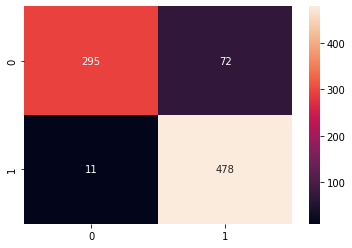

In [60]:
print(f"Accuracy Score: {accuracy_score(pred_df['Type'],pred_df['pred'])*100}")
sns.heatmap(confusion_matrix(pred_df['Type'],pred_df['pred']), annot=True, fmt='2d');

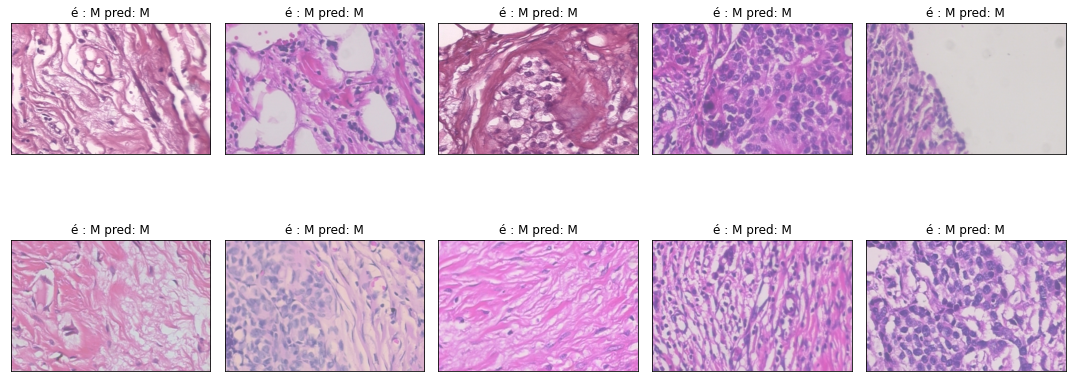

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ponteiro = np.random.randint(1,400)
    ax.imshow(plt.imread(list(pred_df.FikePath)[ponteiro]))
    ax.set_title(f'é : {list(pred_df.Type)[ponteiro]} pred: {list(pred_df.pred)[ponteiro]}')
plt.tight_layout()
plt.show()

#Aqui começa a de 100


Primeiro iremos realizar um teste com os dados pré treinados de 400x, caso atinja uma valor aceitavel, ele será utilizado. Caso não seja, realizaremos um treinamento com 25 epocas

In [62]:
df_geral_100 =  montar_data_frame(r'/content/drive/MyDrive/TCC/100X')
df_treino_100 = df_geral_100[df_geral_100['DataSet'] == 'Tr'][df_geral_100['Magnification'] == '100x']
df_teste_100 = df_geral_100[df_geral_100['DataSet'] == 'Te'][df_geral_100['Magnification'] == '100x']
df_treino_100 = df_treino_100.drop(columns=['Magnification','DataSet'])
df_teste_100 = df_teste_100.drop(columns=['Magnification','DataSet'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [63]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [64]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_100,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df_treino_100,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=df_teste_100,
    x_col='FikePath',
    y_col='Type',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 640 validated image filenames belonging to 2 classes.
Found 160 validated image filenames belonging to 2 classes.
Found 873 validated image filenames belonging to 2 classes.


In [ ]:
Resnet100 = build_model()
checkpoint_path = r'/content/drive/MyDrive/TCC/ResNet50MB.h5'
Resnet100.load_weights(checkpoint_path)
Resnet100.summary()

In [66]:
Resnet100.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

In [68]:
loss, acc = Resnet100.evaluate(test_images, verbose=2)
print("Modelo sem treinamento 100x, accuracy: {:5.2f}%".format(100 * acc))

55/55 - 333s - loss: 0.8530 - accuracy: 0.7675
Modelo sem treinamento 100x, accuracy: 76.75%
